# Introduction to Pyro

Probability is the mathematics of reasoning under uncertainty, much as calculus is the mathematics for reasoning about rates of change. It provides a unifying theoretical framework for understanding much of modern machine learning and AI: models built in the language of probability can capture complex reasoning, know what they do not know, and uncover structure in data without supervision. 

Specifying probabilistic models directly can be cumbersome and implementing them can be very error-prone. Probabilistic programming languages (PPLs) solve these problems by marrying probability with the representational power of programming languages. A probabilistic program is a mix of ordinary deterministic computation and randomly sampled values representing a *generative process* for data.

By observing the outcome of a probabilistic program, we can describe an *inference* problem, roughly translated as: “what must be true if this random choice had a certain observed value?”  PPLs explicitly enforce a separation of concerns already implicit in the mathematics of probability between the specification of a model, a query to be answered, and an algorithm for computing the answer.

Pyro is a probabilistic programming language built on Python and PyTorch. Pyro programs are just Python programs, while its main inference technology is *stochastic variational inference*, which converts abstract probabilistic computations into concrete optimization problems solved with stochastic gradient descent in PyTorch, making probabilistic methods applicable to previously intractable model and dataset sizes.

In this tutorial, we take a brief, opinionated tour of the basic concepts of probabilistic machine learning and probabilistic programming with Pyro. We do so via an example data analysis problem involving linear regression, one of the most common and basic tasks in machine learning. We will see how to use Pyro's modeling language and inference algorithms to incorporate uncertainty into estimates of regression coefficients.

## Outline

- [Introduction](#Introduction-to-Pyro)
- [Outline](#Outline)
- [Setup](#Setup)
- [Background: probabilistic machine learning](#Background:-probabilistic-machine-learning)
  - [Background: probabilistic models](#Background:-probabilistic-models)
  - [Background: inference, learning and evaluation](#Background:-inference,-learning-and-evaluation)
- [Example: Geography and national income](#Example:-Geography-and-national-income)
- [Models in Pyro](#Models-in-Pyro)
  - [Example model: Maximum-likelihood linear regression](#Example-model:-Maximum-likelihood-linear-regression)
  - [Background: the pyro.sample primitive](#Background:-the-pyro.sample-primitive)
  - [Background: the pyro.param primitive](#Background:-the-pyro.param-primitive)
  - [Background: the pyro.plate primitive](#Background:-the-pyro.plate-primitive)
  - [Example: from maximum likelihood regression to Bayesian regression](#Example:-from-maximum-likelihood-regression-to-Bayesian-regression)
- [Inference in Pyro](#Inference-in-Pyro)
  - [Background: variational inference](#Background:-variational-inference)
  - [Background: "guide" programs as flexible approximate posteriors](#Background:-%22guide%22-programs-as-flexible-approximate-posteriors)
  - [Example: mean-field variational approximation for Bayesian linear regression in Pyro](#Example:-mean-field-variational-approximation-for-Bayesian-linear-regression-in-Pyro)
  - [Background: Estimating and optimizing the Evidence Lower Bound (ELBO)](#Background:-Estimating-and-optimizing-the-Evidence-Lower-Bound-(ELBO))
  - [Example: Bayesian regression via stochastic variational inference (SVI)](#Example:-Bayesian-regression-via-stochastic-variational-inference-(SVI))
- [Model Evaluation in Pyro](#Model-Evaluation-in-Pyro)
  - [Background: Bayesian model evaluation with posterior predictive checks](#Background:-Bayesian-model-evaluation-with-posterior-predictive-checks)
  - [Example: posterior predictive uncertainty in Pyro](#Example:-posterior-predictive-uncertainty-in-Pyro)
  - [Example: revisiting Bayesian regression with a full-rank guide](#Example:-revisiting-Bayesian-regression-with-a-full-rank-guide)
- [Next steps](#Next-steps)

## Setup
Let's begin by importing the modules we'll need.

In [1]:
%reset -s -f

In [2]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

/zhome/51/e/115509/.virtualenvs/al/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.2')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

## Background: probabilistic machine learning

Most data analysis problems can be understood as elaborations on three basic high-level questions:

1. What do we know about the problem before observing any data?
2. What conclusions can we draw from data given our prior knowledge?
3. Do these conclusions make sense?

In the probabilistic or Bayesian approach to data science and machine learning, we formalize these in terms of mathematical operations on probability distributions.

### Background: probabilistic models

First, we express everything we know about the variables in a problem and the relationships between them in the form of a ***probabilistic model***, or a joint probability distribution over a collection of random variables. A model has observations ${\bf x}$ and latent random variables ${\bf z}$ as well as parameters $\theta$. It usually has a joint density function of the form 

$$p_{\theta}({\bf x}, {\bf z}) = p_{\theta}({\bf x}|{\bf z}) p_{\theta}({\bf z})$$

The distribution over latent variables $p_{\theta}({\bf z})$ in this formula is called the ***prior***, and the distribution over observed variables given latent variables $p_{\theta}({\bf x}|{\bf z})$ is called the ***likelihood***.

We typically require that the various conditional probability distributions $p_i$ that make up a model $p_{\theta}({\bf x}, {\bf z})$ have the following properties (generally satisfied by the distributions available in [Pyro](http://docs.pyro.ai/en/stable/distributions.html) and [PyTorch Distributions](https://pytorch.org/docs/stable/distributions.html)):

- we can efficiently sample from each $p_i$
- we can efficiently compute the pointwise probability density $p_i$ 
- $p_i$ is differentiable w.r.t. the parameters $\theta$

Probabilistic models are often depicted in a [standard graphical notation](https://en.wikipedia.org/wiki/Bayesian_network) for visualization and communication, summarized below, although it is possible in Pyro to represent models that do not have a fixed graphical structure. In models with lots of repetition, it is convenient to use ***plate*** notation, so called because it is shown graphically as a rectangular "plate" around variables to indicate multiple independent copies of the random variables inside.

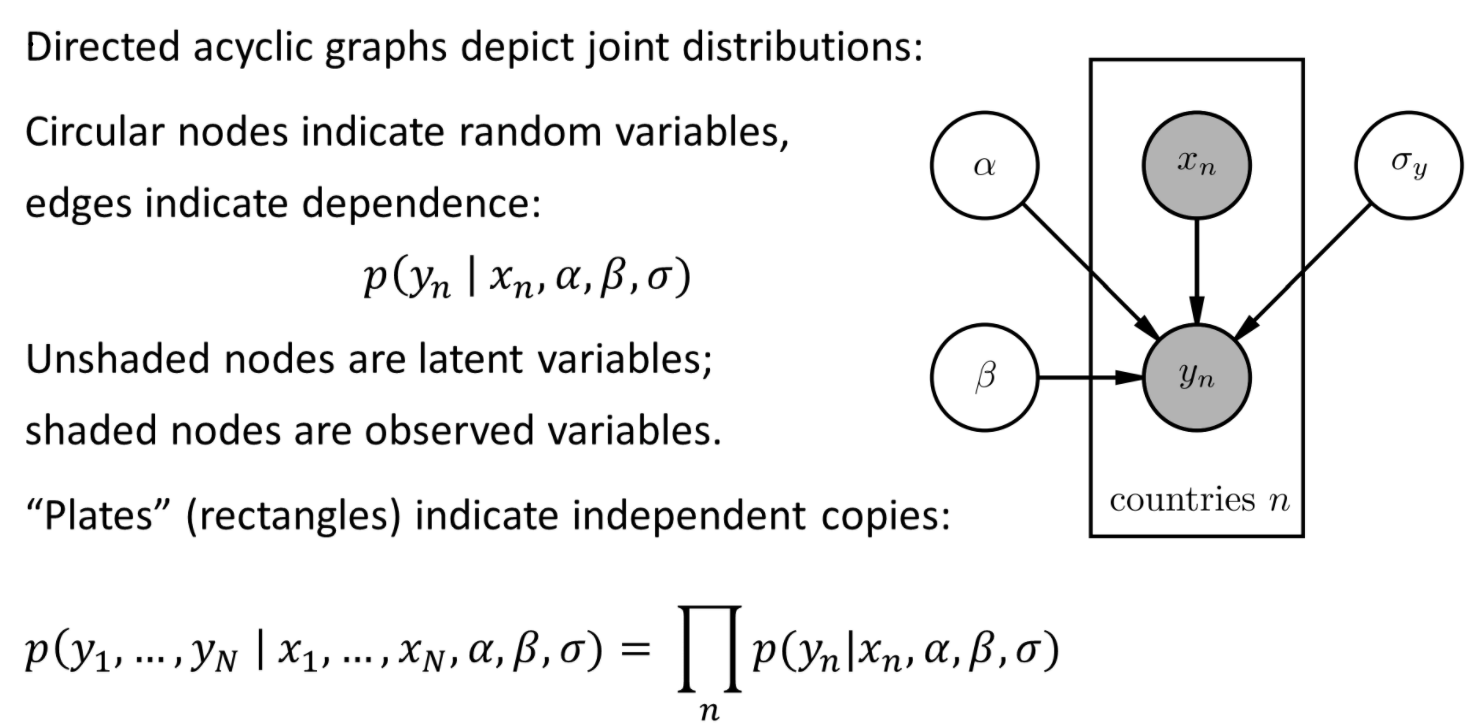

### Background: inference, learning and evaluation

Once we have specified a model, Bayes' rule tells us how to use it to perform ***inference***, or draw conclusions about latent variables from data, by computing the ***posterior distribution*** over $\bf z$:

$$ p_{\theta}({\bf z} | {\bf x}) = \frac{p_{\theta}({\bf x} , {\bf z})}{
\int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z}) } $$

To check the results of modeling and inference, we would like to know how well a model fits observed data $x$, which we can quantify with the ***evidence*** or ***marginal likelihood***

$$p_{\theta}({\bf x}) = \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z}) $$

and also to make predictions for new data, which we can do with the ***posterior predictive distribution***

$$p_{\theta}(x' | {\bf x}) = \int \! d{\bf z}\; p_{\theta}(x' | {\bf z}) p_{\theta}({\bf z} | {\bf x}) $$

Finally, it is often desirable to ***learn*** the parameters $\theta$ of our models from observed data $x$, which we can do by maximizing the marginal likelihood:

$$\theta_{\rm{max}} = \rm{argmax}_\theta p_{\theta}({\bf x}) = \rm{argmax}_\theta \int \! d{\bf z}\; p_{\theta}({\bf x} , {\bf z}) $$

## Example: Geography and national income

The following example is adapted from Chapter 7 of the excellent book [*Statistical Rethinking*](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath, which readers are encouraged to review for an accessible introduction to the broader practice of Bayesian data analysis ([Pyro code for all chapters](https://fehiepsi.github.io/rethinking-pyro/) is available).

We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors of the original paper (["Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)) that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. 

Let us look at the data and investigate this relationship.  We will be focusing on three features from the dataset:

  - `rugged`: quantifies the Terrain Ruggedness Index;
  - `cont_africa`: whether the given nation is in Africa;
  - `rgdppc_2000`: Real GDP per capita for the year 2000;

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

The response variable GDP is highly skewed, so we will log-transform it before proceeding.

In [5]:
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

We then convert the Numpy array behind this dataframe to a `torch.Tensor` for analysis with PyTorch and Pyro.

In [6]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

Visualizing the data suggests that there is indeed a possible relationship between ruggedness and GDP, but that further analysis will be needed to confirm it. We will see how to do this in Pyro via Bayesian linear regression.

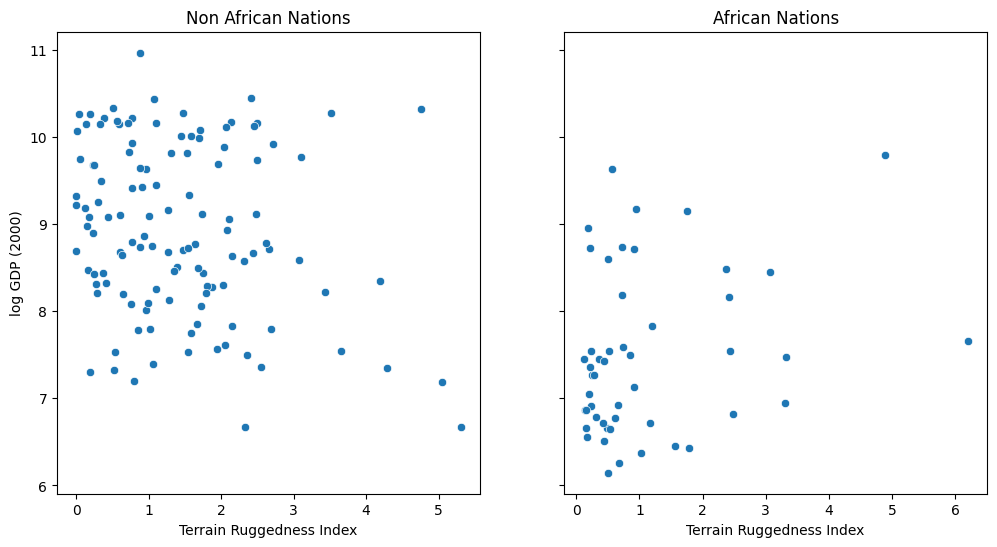

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"], 
                y=non_african_nations["rgdppc_2000"], 
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"], 
                y=african_nations["rgdppc_2000"], 
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## Models in Pyro

Probabilistic models in Pyro are specified as Python functions `model(*args, **kwargs)` that generate observed data from latent variables using [special primitive functions](https://docs.pyro.ai/en/stable/primitives.html) whose behavior can be changed by Pyro's internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of `model()` are encoded via the mapping:

1. latent random variables $z$ $\Longleftrightarrow$ [pyro.sample](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.sample)
2. observed random variables $x$ $\Longleftrightarrow$ [pyro.sample](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.sample) with the `obs` keyword argument
3. learnable parameters $\theta$ $\Longleftrightarrow$ [pyro.param](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.param)
4. plates $\Longleftrightarrow$ [pyro.plate](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.plate) context managers

We examine each of these components in detail below in the context of a first Pyro model for linear regression.

### Example model: Maximum-likelihood linear regression

If we write out the formula for our linear regression predictor $\beta X + \alpha$ as a Python expression, we get the following:

```py
mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
```

To build this up into a full probabilistic model for our dataset, we need to make the regression coefficients $\alpha$ and $\beta$ learnable parameters and add observation noise around the predicted mean. We can express this using the Pyro primitives introduced above and visualize the resulting model using [pyro.render_model()](https://docs.pyro.ai/en/latest/infer.util.html?highlight=render_model#pyro.infer.inspect.render_model):

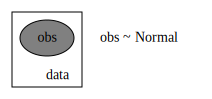

In [8]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)
    
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    
    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

The above plot does not show the model parameters `a`, `b_a`, `b_r`, `b_ar`, and `sigma`. We can set `render_params=True` to render the model parameters.

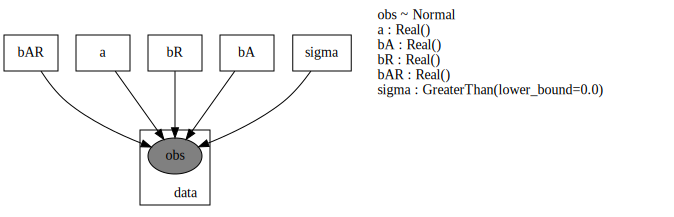

In [9]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

The argument `render_distributions = True` will show constraints on the parameters. For example, `sigma` is a standard deviation that should be non-negative. Thus, its constraint is shown as "sigma $\in$ GreaterThan(lower_bound=0.0)".

Learning the parameters of `simple_model` would constitute **maximum likelihood estimation** and produce point estimates of the regression coefficients. However, in this example our data visualization suggests we should not be too confident in any single value for the regression coefficients. By contrast, a fully Bayesian approach would produce uncertainty estimates over different possible parameter values as well as the model's predictions.

Before making a Bayesian version of our linear model, let's pause and take a closer look at this first piece of Pyro code.

### Background: the `pyro.sample` primitive

Probabilistic programs in Pyro are built up around samples from primitive probability distributions, marked by `pyro.sample`:
```python
def sample(
    name: str,
    fn: pyro.distributions.Distribution,
    *,
    obs: typing.Optional[torch.Tensor] = None,
    infer: typing.Optional[dict] = None
) -> torch.Tensor:
    ...
```

In our model `simple_model` above, the line
```python
return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```
can represent either a latent variable or an observed variable depending on whether `simple_model` is given a `log_gdp` value. When `log_gdp` is not provided and `"obs"` is latent, it is equivalent (ignoring the `pyro.plate` context for now by assuming `len(ruggedness) == 1`) to calling the distribution's underlying `.sample` method:
```python
return dist.Normal(mean, sigma).sample()
```
This interpretation is behind occasional references to Pyro programs as ***stochastic functions***, a rather obscure term used in some of Pyro's older documentation.

When `simple_model` is given a `log_gdp` argument and `"obs"` is observed, the `pyro.sample` statement
```python
return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```
will always return `log_gdp`:
```python
return log_gdp
```
However, note that **when any sample statement is observed, the cumulative effect of *every other sample statement in a model* changes** following Bayes' rule; it is the job of Pyro's [inference algorithms](https://docs.pyro.ai/en/stable/inference.html) to "run the program backwards" and assign mathematically consistent values to all `pyro.sample` statements in a model.

A reasonable question to ask at this point is why `pyro.sample` and other primitives must have names. Names are leveraged by users and by Pyro's internals to separate specifications of model, observations and inference algorithms, a key selling point of probabilistic programming languages. 
To see an example of this, we can look at the higher-order primitive [pyro.condition](https://docs.pyro.ai/en/stable/poutine.html#pyro.poutine.handlers.condition) which addresses the problem of writing many queries against a single Pyro model:
```python
def condition(
    model: Callable[..., T],
    data: Dict[str, torch.Tensor]
) -> Callable[..., T]:
    ...
```
`pyro.condition` takes a model and a (possibly empty) dictionary mapping names to observed values and passes each observation to the `pyro.sample` statement indicated by its name. In the context of our example `simple_model`, we could remove `log_gdp` as an argument and replace it with a simpler interface
```python
def simpler_model(is_cont_africa, ruggedness): ...

conditioned_model = pyro.condition(simpler_model, data={"obs": log_gdp})
```
where `conditioned_model` is equivalent to
```python
conditioned_model = functools.partial(simple_model, log_gdp=log_gdp)
```

### Background: the `pyro.param` primitive

The next primitive used in our model, [pyro.param](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.param), is a frontend for reading from and writing to Pyro's [key-value parameter store](https://docs.pyro.ai/en/stable/parameters.html#pyro.params.param_store.ParamStoreDict):
```python
def param(
    name: str,
    init: Optional[Union[torch.Tensor, Callable[..., torch.Tensor]]] = None,
    *,
    constraint: torch.distributions.constraints.Constraint = constraints.real
) -> torch.Tensor:
    ...
```

Like `pyro.sample`, `pyro.param` is always called with a name as its first argument.  The first time `pyro.param` is called with a particular name, it stores the initial value specified by the second argument `init` in the parameter store and then returns that value.  After that, when it is called with that name, it returns the value from the parameter store regardless of any other arguments.  After a parameter has been initialized, it is no longer necessary to specify `init` to retrieve its value (e.g. `pyro.param("a")`).

The second argument, `init`, can be either a `torch.Tensor` or a function that takes no arguments and returns a tensor. The second form is useful because it avoids repeatedly constructing initial values that are only used the first time a model is run.

Unlike PyTorch's `torch.nn.Parameter`s, parameters in Pyro can be explicitly constrained to various subsets of $\mathbb{R}^n$, an important feature because many elementary probability distributions have parameters with restricted domains. For example, the `scale` parameter of a `Normal` distribution must be positive. The optional third argument to `pyro.param`, `constraint`, is a [torch.distributions.constraints.Constraint](https://docs.pyro.ai/en/stable/distributions.html#module-pyro.distributions.constraints) object stored when a parameter is initialized; constraints are reapplied after every update. Pyro ships with a large number of predefined constraints. 

`pyro.param` values persist across model calls, unless the parameter store is updated by an optimization algorithm or cleared via [pyro.clear_param_store()](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.clear_param_store). Unlike `pyro.sample`, `pyro.param` can be called with the same name multiple times in a model; every call with the same name will return the same value. The global parameter store itself is accessible by calling [pyro.get_param_store()](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.get_param_store).

In our model `simple_model` above, the statement 
```python
a = pyro.param("a", lambda: torch.randn(()))
```
is similar conceptually to the code below, but with some additional tracking, serialization and constraint management functionality.

```python
simple_param_store = {}
...
def simple_model():
    a_init = lambda: torch.randn(())
    a = simple_param_store["a"] if "a" in simple_param_store else a_init()
    ...
```
While this introductory tutorial uses `pyro.param` for parameter management, Pyro is also compatible with PyTorch's familiar `torch.nn.Module` API via [pyro.nn.PyroModule](https://docs.pyro.ai/en/stable/nn.html#module-pyro.nn.module).

### Background: the `pyro.plate` primitive

[pyro.plate](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.plate) is Pyro's formal encoding of [plate notation](https://en.wikipedia.org/wiki/Plate_notation), widely used in probabilistic machine learning to simplify visualization and analysis of models with lots of conditionally [independent and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) random variables.
```python
def plate(
    name: str,
    size: int,
    *,
    dim: Optional[int] = None,
    **other_kwargs
) -> contextlib.AbstractContextManager:
    ...
```

Conceptually, `pyro.plate` statements are equivalent to a `for`-loop. In `simple_model`, we could replace the lines
```python
with pyro.plate("data", len(ruggedness)):
    return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```
with a Python `for`-loop
```python
result = torch.empty_like(ruggedness)
for i in range(len(ruggedness)):
    result[i] = pyro.sample(f"obs_{i}", dist.Normal(mean, sigma), obs=log_gdp[i] if log_gdp is not None else None)
return result
```
When the number of repeated variables (`len(ruggedness)` in this case) is large, using a Python loop would be quite slow. Since each iteration in the loop is independent of the others, `pyro.plate` uses PyTorch's [array broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) to perform the iterations in parallel in a single vectorized operation, as in this equivalent vectorized code:
```python
mean = mean.unsqueeze(-1).expand((len(ruggedness),))
sigma = sigma.unsqueeze(-1).expand((len(ruggedness),))
return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)
```

Practically speaking, when writing Pyro programs `pyro.plate` is most useful as a tool for vectorization. However, as described in [part 2 of the SVI tutorial](http://pyro.ai/examples/svi_part_ii.html), it is also useful for managing [data subsampling](https://docs.pyro.ai/en/stable/primitives.html#pyro.primitives.subsample) and as a signal to inference algorithms that certain variables are independent.

### Example: from maximum-likelihood regression to Bayesian regression

In order to make our linear regression model Bayesian, we need to specify *prior distributions* on the parameters $\alpha \in \mathbb{R}$ and $\beta \in \mathbb{R}^3$ (expanded here into scalars `b_a`, `b_r`, and `b_ar`). These are probability distributions that represent our beliefs prior to observing any data about reasonable values for $\alpha$ and $\beta$. We will also add a random scale parameter $\sigma$ that controls the observation noise.

Expressing this Bayesian model for linear regression in Pyro is very intuitive: we simply replace each of the `pyro.param` statements with `pyro.sample` statements equipped with [Pyro Distribution objects](https://docs.pyro.ai/en/stable/distributions.html) describing prior beliefs about each parameter.

For the constant term $\alpha$, we use a Normal prior with a large standard deviation to indicate our relative lack of prior knowledge about baseline GDP. For the other regression coefficients, we use standard Normal priors (centered at 0) to represent our lack of a priori knowledge of whether the relationship between covariates and GDP is positive or negative. For the observation noise $\sigma$, we use a flat prior bounded below by 0 because this value must be positive to be a valid standard deviation.

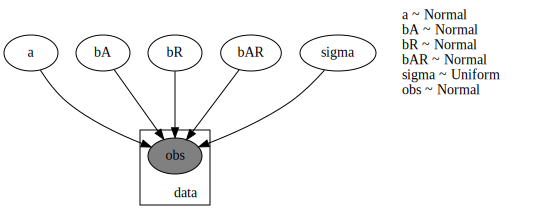

In [10]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    
    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness
    
    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)

## Inference in Pyro

### Background: variational inference

Each of the computations from the introduction (the posterior distribution, the marginal likelihood and the posterior predictive distribution) requires performing integrals that are often impossible or computationally intractable.

While Pyro includes support for many different exact and approximate inference algorithms, the best-supported is variational inference, which offers a unified scheme for finding $\theta_{\rm{max}}$ and computing a tractable approximation $q_{\phi}({\bf z})$ to the true, unknown posterior $p_{\theta_{\rm{max}}}({\bf z} | {\bf x})$ by converting the intractable integrals into optimization of a functional of $p$ and $q$. The figure below depicts this process conceptually, while a more comprehensive mathematical introduction is available in the [SVI tutorials](http://pyro.ai/examples/svi_part_i.html).

Most probability distributions (the light ellipse in the figure below), especially those corresponding to Bayesian posterior distributions, are too complex to represent directly, so we must define a smaller subspace, indexed by real-valued parameters $\phi$, of distributions $q_{\phi}({\bf z})$ that are by construction guaranteed to be easy to sample from (the dark circle in the figure below) but may not include the true posterior distribution $p_{\theta}({\bf z} | {\bf x})$ (the red star in the figure below).

Variational inference approximates the true posterior by searching the space of variational distributions to find one that is most similar to the true posterior (the yellow star in the figure below) according to some measure of distance or divergence (the black arrow in the figure below).

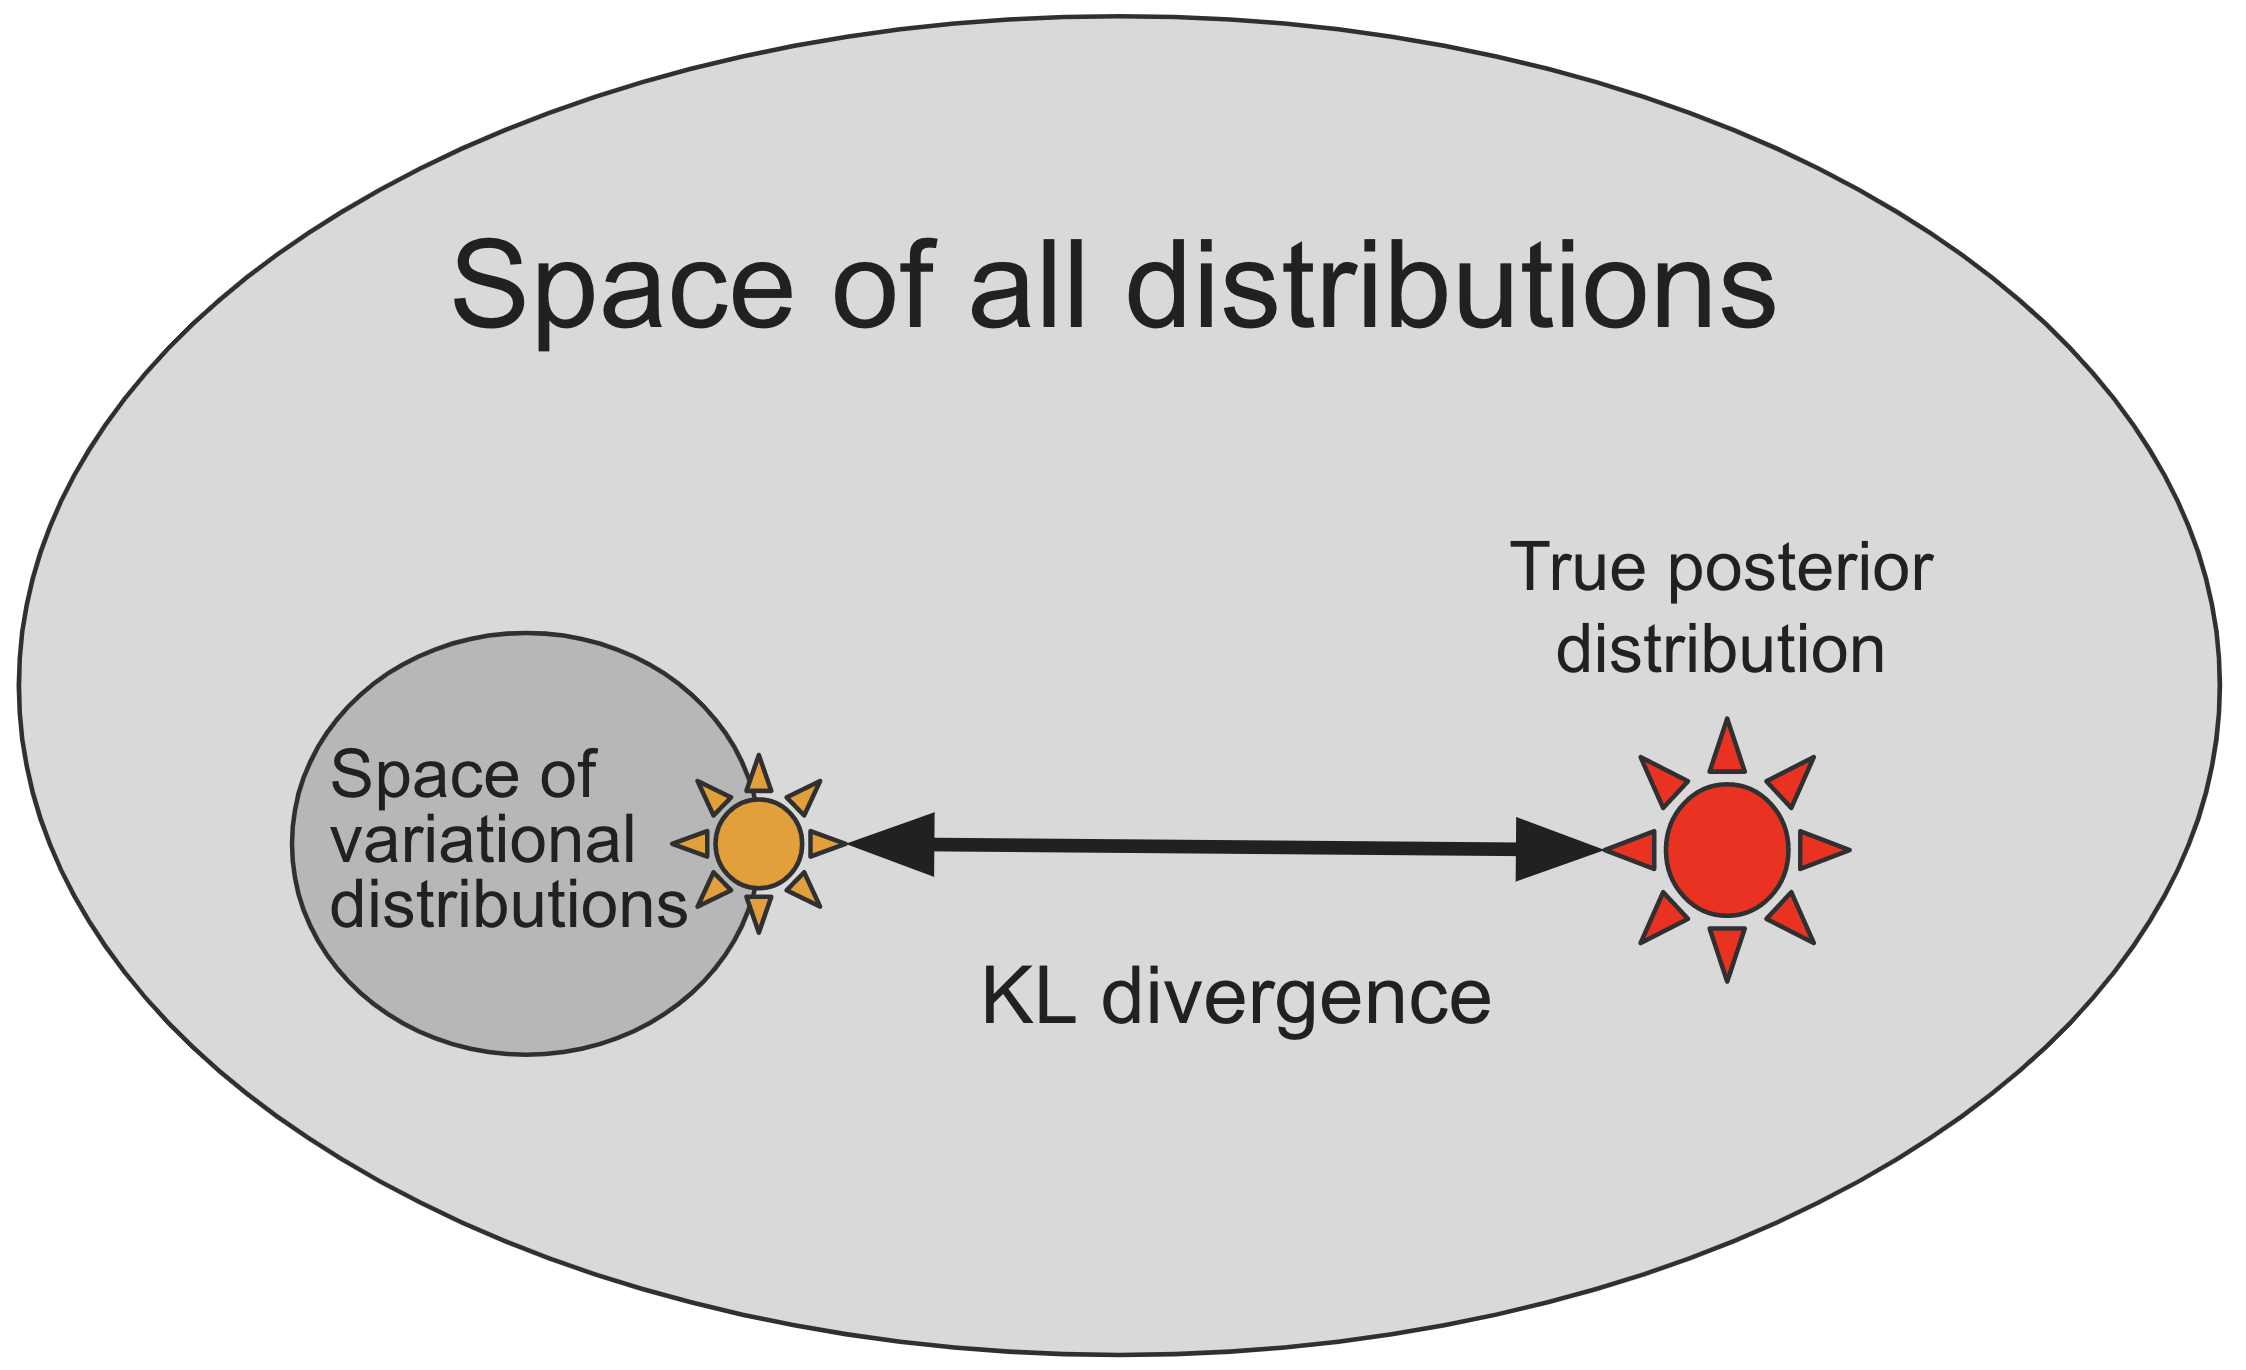

However, there are many different ways to measure distance or divergence between probability distributions. Which one should we choose? As indicated by the figure, a theoretically appealing choice is the Kullback-Leibler divergence $KL(q_{\phi}({\bf z}) || p_{\theta}({\bf z} | {\bf x}))$, but computing this directly requires knowing the true posterior ahead of time, which would defeat the purpose.

What's more, we are interested in optimizing this divergence, which might sound even harder, but in fact it is possible to use Bayes' theorem to rewrite the definition of $KL(q_{\phi}({\bf z}) || p_{\theta}({\bf z} | {\bf x}))$ as the difference between an intractable constant that does not depend on $q_{\phi}$ and a tractable term called the ***evidence lower bound (ELBO)***, defined below. Maximizing this tractable term will therefore produce the same solution as minimizing the original KL-divergence.

### Background: "guide" programs as flexible approximate posteriors

In variational inference, we introduce a parameterized distribution $q_{\phi}({\bf z})$ to approximate the true posterior, where $\phi$ are known as the variational parameters. This distribution is called the variational distribution in much of the literature, and in the context of Pyro it's called the ***guide*** (one syllable instead of nine!).

Just like the model, the guide is encoded as a Python program `guide()` that contains `pyro.sample` and `pyro.param` statements. It does _not_ contain observed data, since the guide needs to be a properly normalized distribution so that it is easy to sample from. Note that Pyro enforces that `model()` and `guide()` should take the same arguments. Allowing guides to be arbitrary Pyro programs opens up the possibility of writing guide families that capture more of the problem-specific structure of the true posterior, expanding the search space in only helpful directions, as depicted schematically in the figure below.

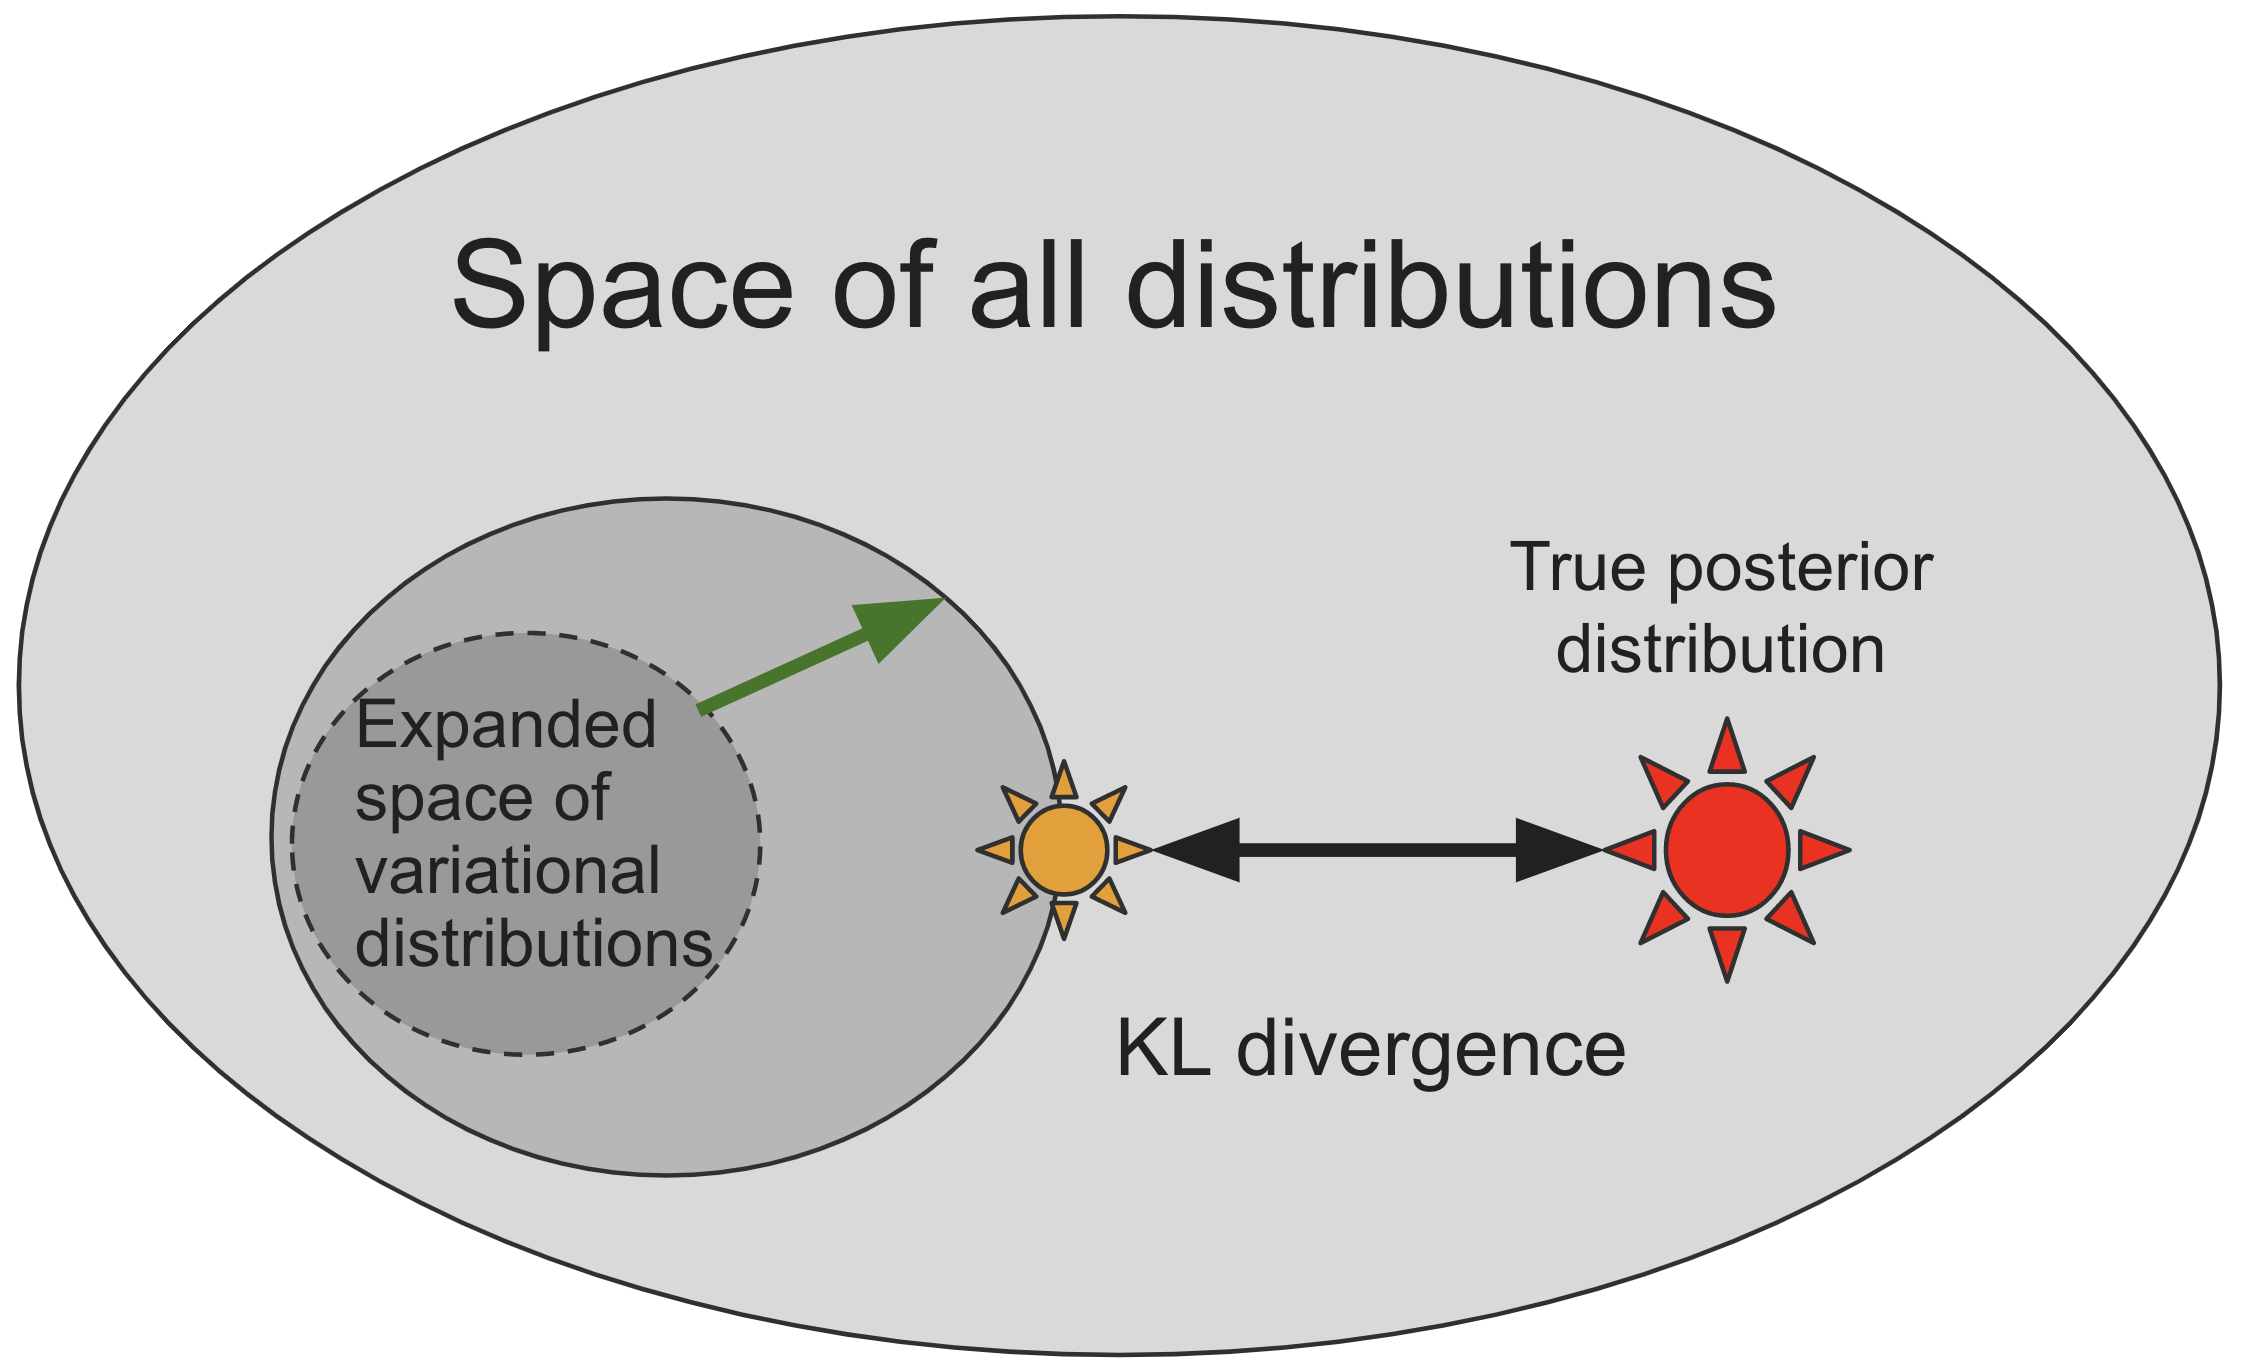

What restrictions on guides are imposed by the math of variational inference? Since the guide is an approximation to the posterior $p_{\theta_{\rm{max}}}({\bf z} | {\bf x})$, the guide needs to provide a valid joint probability density over all the latent random variables in the model. Recall that when random variables are specified in Pyro with the primitive statement `pyro.sample()` the first argument denotes the name of the random variable. These names will be used to align the random variables in the model and guide. To be very explicit, if the model contains a random variable `z_1`

```python
def model():
    pyro.sample("z_1", ...)
```

then the guide needs to have a matching `sample` statement

```python
def guide():
    pyro.sample("z_1", ...)
```

The distributions used in the two cases can be different, but the names must line-up 1-to-1. 

Despite the flexibility it offers, writing out guides by hand can be difficult and tedious, especially for new users. Whenever possible, we recommend using ***autoguides***, or recipes for automatically generating common guide families from models that ship with Pyro in [pyro.infer.autoguide](https://docs.pyro.ai/en/stable/infer.autoguide.html). The next section demonstrates both approaches.

### Example: mean-field variational approximation for Bayesian linear regression in Pyro

For our running example of Bayesian linear regression, we will use a guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong assumption as we shall see). This is known as a ***mean-field approximation***, a term borrowed from physics, where such approximations were originally invented. 

We first write out a guide program of this form by hand for completeness.

In [11]:
def custom_guide(is_cont_africa, ruggedness, log_gdp=None):
    a_loc = pyro.param('a_loc', lambda: torch.tensor(0.))
    a_scale = pyro.param('a_scale', lambda: torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', lambda: torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', lambda: torch.randn(3))
    weights_scale = pyro.param('weights_scale', lambda: torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    return {"a": a, "b_a": b_a, "b_r": b_r, "b_ar": b_ar, "sigma": sigma}

We can use `pyro.render_model` to visualize `custom_guide`, demonstrating that the random variables are indeed independent of one another as indicated by the lack of edges between them.

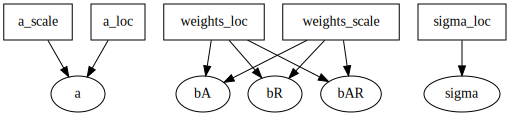

In [12]:
pyro.render_model(custom_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Pyro also contains an extensive collection of "autoguides" which automatically generate guide programs from a given model. Like our handwritten guide, all `pyro.autoguide.AutoGuide` instances (which are themselves just functions that take the same arguments as the model) return a dictionary of values for each `pyro.sample` site they contain. 

The simplest autoguide class is `AutoNormal`, which automatically generates a guide in a single line of code that is equivalent to the one we wrote out by hand above:

In [13]:
auto_guide = pyro.infer.autoguide.AutoNormal(model)

The guide alone does not fully specify an inference algorithm, however: it merely describes the search space over possible approximate posterior distributions indexed by parameters (the dark circle in the figure above) and an initial point in that space determined by the initial parameter values. We must then move this initial distribution towards the true posterior distribution (the red star in the figure above) by solving an optimization problem over the parameters (the yellow star in the figure above). Formulating and solving this optimization problem is the subject of the next two sections.

### Background: Estimating and optimizing the Evidence Lower Bound (ELBO)

The functional of model $p_{\theta}({\bf x}, {\bf z})$ and guide $q_{\phi}({\bf z})$ that we will optimize is the ELBO, defined as an expectation w.r.t. to samples from the guide:

$${\rm ELBO} \equiv \mathbb{E}_{q_{\phi}({\bf z})} \left [ 
\log p_{\theta}({\bf x}, {\bf z}) - \log q_{\phi}({\bf z})
\right]$$

By assumption we can compute all of the probabilities inside the expectation, and since the guide $q$ is assumed to be a parametric distribution we can sample from, we can compute Monte Carlo estimates of this quantity as well as of gradients with respect to model and guide parameters, $\nabla_{\theta,\phi}ELBO$.

Optimizing the ELBO over model and guide parameters $\theta,\phi$ via stochastic gradient descent using these gradient estimates is sometimes called *stochastic variational inference* (SVI); for an extended introduction to SVI, see [SVI Part I](https://pyro.ai/examples/svi_part_i.html). 

### Example: Bayesian regression via stochastic variational inference (SVI)

Pyro contains [a number of different implementations](https://docs.pyro.ai/en/stable/inference_algos.html#module-pyro.infer.elbo) of estimators for the ELBO (defined mathematically in the previous section) that each compute losses and gradients slightly differently with different tradeoffs. In this tutorial we will only use [pyro.infer.Trace_ELBO](https://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.trace_elbo.Trace_ELBO), which is always correct and safe to do; other ELBO estimators may provide computational or statistical advantages for certain models and guides.

We will use SVI for inference in our example model, demonstrating how Pyro uses PyTorch's stochastic gradient descent implementations to optimize the output of a `pyro.infer.Trace_ELBO` object that we pass to [pyro.infer.SVI](https://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.svi.SVI), which is a helper class whose `step()` method takes care of computing the loss and parameter gradients and applying updates and constraints to parameters. 

In [14]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

Here [pyro.optim.Adam](https://docs.pyro.ai/en/stable/optimization.html#pyro.optim.pytorch_optimizers.Adam) is a thin wrapper around the PyTorch optimizer [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) (see [here](https://pyro.ai/examples/svi_part_i.html#Optimizers) for a discussion). Optimizers in `pyro.optim` are used to optimize and update parameter values in Pyro's parameter store. In particular, you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the `SVI` class automatically. To take an ELBO gradient step we simply call the step method of SVI. The data argument we pass to `SVI.step` will be passed to both `model()` and `guide()`. The complete training loop is as follows:

Elbo loss: 694.9404826164246
Elbo loss: 524.3822101354599
Elbo loss: 475.66820669174194
Elbo loss: 399.99088364839554
Elbo loss: 315.23274326324463
Elbo loss: 254.76771265268326
Elbo loss: 248.237040579319
Elbo loss: 248.42670530080795
Elbo loss: 248.46450632810593
Elbo loss: 257.41463351249695


CPU times: user 6.59 s, sys: 0 ns, total: 6.59 s
Wall time: 6.6 s


Text(0, 0.5, 'ELBO loss')

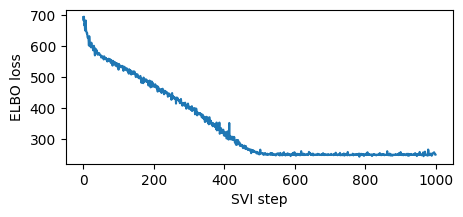

In [15]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

Note this training was fast since we used a high learning rate. Sometimes models and guides are sensitive to learning rate, and the first thing to try is decreasing learning rate and increasing number of steps. This is espcially important in models and guides with deep neural nets. We recommend starting with a lower learning rate and gradually increasing, avoiding learning rates that are too fast, where inference can diverge or result in NANs.

Having trained a guide, we can examine the optimized guide parameter values by fetching from Pyro's param store. Each `(loc, scale)` pair printed below parametrize a single `pyro.distributions.Normal` distribution in the guide corresponding to a different unobserved `pyro.sample` statement in the model, similar to our handwritten `custom_guide` from before.

In [16]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.173145
AutoNormal.scales.a 0.0703669
AutoNormal.locs.bA -1.8474661
AutoNormal.scales.bA 0.1407009
AutoNormal.locs.bR -0.19032118
AutoNormal.scales.bR 0.044044234
AutoNormal.locs.bAR 0.35599768
AutoNormal.scales.bAR 0.079374395
AutoNormal.locs.sigma -2.205863
AutoNormal.scales.sigma 0.060526706


Finally, let us revisit our earlier question of how robust the relationship between terrain ruggedness and GDP is against any uncertainty in the parameter estimates from our model. For this, we plot the distribution of the slope of the log GDP given terrain ruggedness for nations within and outside Africa.

We represent these two distributions with samples drawn from our trained guide. To draw multiple samples in parallel, we can call the guide within a `pyro.plate` statement which repeats and vectorizes the sampling operations for each `pyro.sample` statement in the guide, as described in the section introducing the `pyro.plate` primitive.

In [17]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]

As can be seen below, the probability mass for African nations is largely concentrated in the positive region and vice-versa for other nations, lending further credence to the original hypothesis. However, the posterior uncertainty for the non-African nations (the width of the orange histogram) appears substantially lower than for African nations (the width of the blue histogram), which is surprising given the seemingly similar spread in the original data. We will investigate this discrepancy further in the next section.

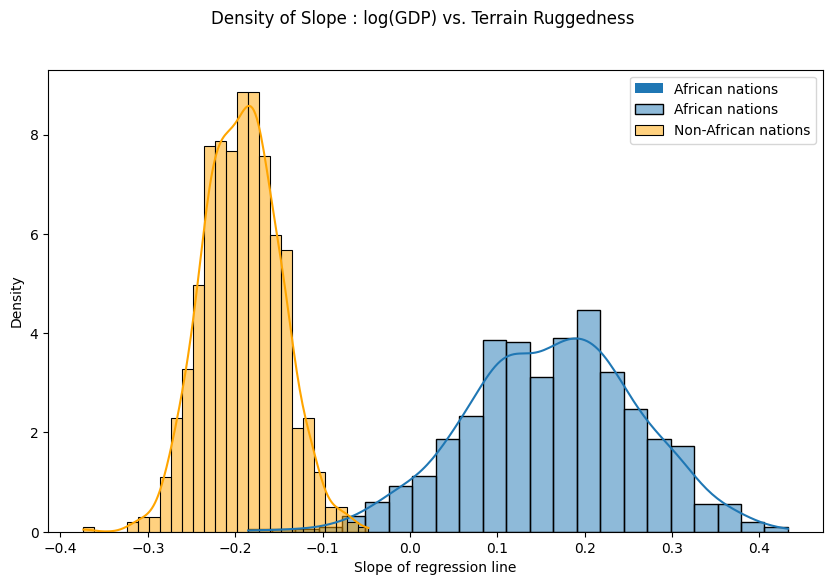

In [18]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

## Model Evaluation in Pyro

### Background: Bayesian model evaluation with posterior predictive checks

To assess whether we can trust the results of our inference, we will compare the posterior predictive distribution over possible new data induced by our model to the existing observed data. Computing this distribution is intractable in general because it depends on knowing the true posterior, but we can easily approximate it using our approximate posterior obtained from variational inference:

$$p_{\theta}(x' | {\bf x}) = \int \! d{\bf z}\; p_{\theta}(x' | {\bf z}) p_{\theta}({\bf z} | {\bf x})
\approx \int \! d{\bf z}\; p_{\theta}(x' | {\bf z}) q_{\phi}({\bf z} | {\bf x})$$

Concretely, to draw an approximate sample from the posterior predictive, we simply draw a sample ${\hat {\bf z}} \sim q_{\phi}({\bf z})$ from the approximate posterior, then sample from the distribution over observed variables in our model given that sample $x' \sim p_{\theta}(x | {\hat {\bf z}})$, as if we had replaced the prior with our (approximate) posterior.

### Example: posterior predictive uncertainty in Pyro

To evaluate our example linear regression model, we'll generate and visualize some samples from the posterior predictive distribution using the [Predictive](http://docs.pyro.ai/en/stable/inference_algos.html#pyro.infer.predictive.Predictive) utility class, which implements the recipe above for sampling approximately from $p_{\theta}(x' | {\bf x})$.

We generate 800 samples from our trained model. Internally, this is done by first generating samples for the latent variables from the `guide`, and then running the model forward while changing the values returned by unobserved `pyro.sample` statements to the corresponding values sampled from the `guide`.

In [19]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

The code below is specific to this example and is simply used to plot the 90% credible interval (the interval containing 90% of the probability mass) of the posterior predictive distribution for each country.

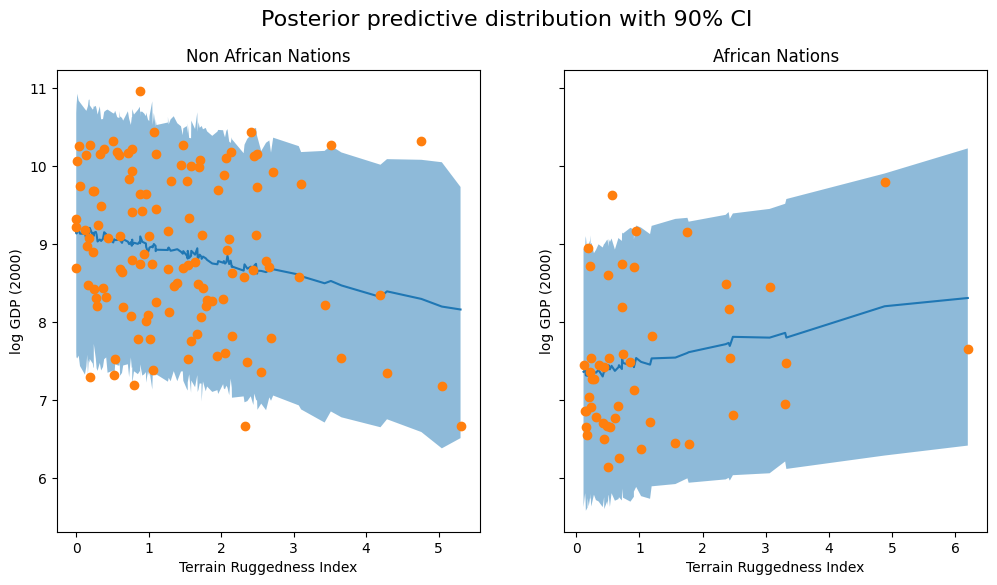

In [20]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice, but there are still quite a few non-African nations that are considered unlikely by our approximate posterior.

### Example: revisiting Bayesian regression with a full-rank guide

To improve our results, we will try using a guide that generates samples from a multivariate normal distribution over all parameters.  This allows us to capture the correlations between the latent variables via a full-rank covariance matrix $\Sigma \in \mathbb{R}^{5 \times 5}$; our previous guide ignored these correlations. That is, we have

$$\alpha, \beta_a, \beta_r, \beta_{ar}, \sigma_u \sim q_{\phi = ({\bf \mu}, {\bf \Sigma})}(\alpha, \beta_a, \beta_r, \beta_{ar}, \sigma_u) = \rm{Normal}((\alpha, \beta_a, \beta_r, \beta_{ar}, \sigma_u) | {\bf \mu}, {\bf \Sigma})$$

$$\sigma = \rm{constrain}(\sigma_u)$$

To write a guide of this form manually, we would need to combine all the latent variables so we could `pyro.sample` them together from a single `pyro.distributions.MultivariateNormal` distribution, choose an implementation of $\rm{constrain}()$ to fix the value of $\sigma$ to be positive, create and initialize parameters $\mu, \Sigma$ of the appropriate shape, and constrain the variational parameter $\Sigma$ to remain a valid covariance matrix (i.e. stay positive-definite) throughout the optimization process.

This would be quite tedious, so instead we will use another autoguide that takes care of all of this bookkeeping for us, [pyro.infer.autoguide.AutoMultivariateNormal](https://docs.pyro.ai/en/stable/infer.autoguide.html#automultivariatenormal):

In [21]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

Using `pyro.render_model` demonstrates that unlike our mean-field `AutoNormal` guide, this guide explicitly captures the correlations between all latent variables in our model. The new `_AutoMultivariateNormal_latent` node in the visualized graph corresponds to the equation above; the other nodes corresponding to model variables simply index into individual elements of this tensor-valued random variable.

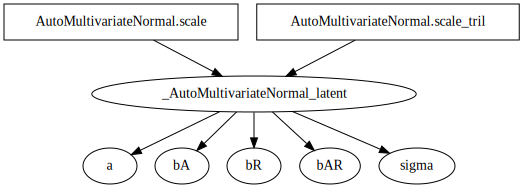

In [22]:
pyro.render_model(mvn_guide, model_args=(is_cont_africa, ruggedness, log_gdp), render_params=True)

Our model and the rest of our inference and evaluation code is essentially unchanged from before: we use `pyro.optim.Adam` and `pyro.infer.Trace_ELBO` to fit the new guide's parameters, then sample from the guide and use `Predictive` to sample from the posterior predictive distribution.

There is one minor difference worth noting: we reuse the guide samples for prediction by passing them directly to `Predictive` via its `posterior_samples` keyword argument instead of passing the guide as in the previous section. This avoids unnecessarily repeating computation.

Elbo loss: 702.4906432628632
Elbo loss: 548.7575962543488
Elbo loss: 490.96424263715744
Elbo loss: 401.81392109394073
Elbo loss: 333.7779415845871
Elbo loss: 247.0182519555092
Elbo loss: 248.38943058252335
Elbo loss: 247.35121273994446
Elbo loss: 248.20958936214447
Elbo loss: 247.21006894111633


CPU times: user 5.4 s, sys: 4.89 ms, total: 5.41 s
Wall time: 5.42 s


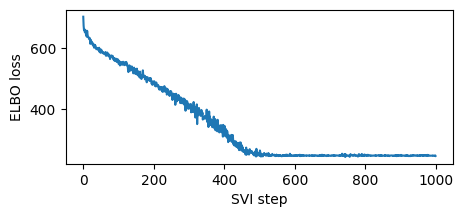

In [23]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model, 
                     mvn_guide, 
                     pyro.optim.Adam({"lr": 0.02}), 
                     pyro.infer.Trace_ELBO(num_particles=17, vectorize_particles=True))

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")
        
with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

Now let's compare the posterior computed by the previous `AutoDiagonalNormal` guide vs the `AutoMultivariateNormal` guide.  We will visually overlay cross-sections of the posterior distribution (joint distributions of pairs of regression coefficients).

Note that the multivariate normal approximation is more dispersed than the mean-field approximation, and is able to model correlations between coefficients in the posterior.

/tmp/ipykernel_195675/4109849576.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
/tmp/ipykernel_195675/4109849576.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)


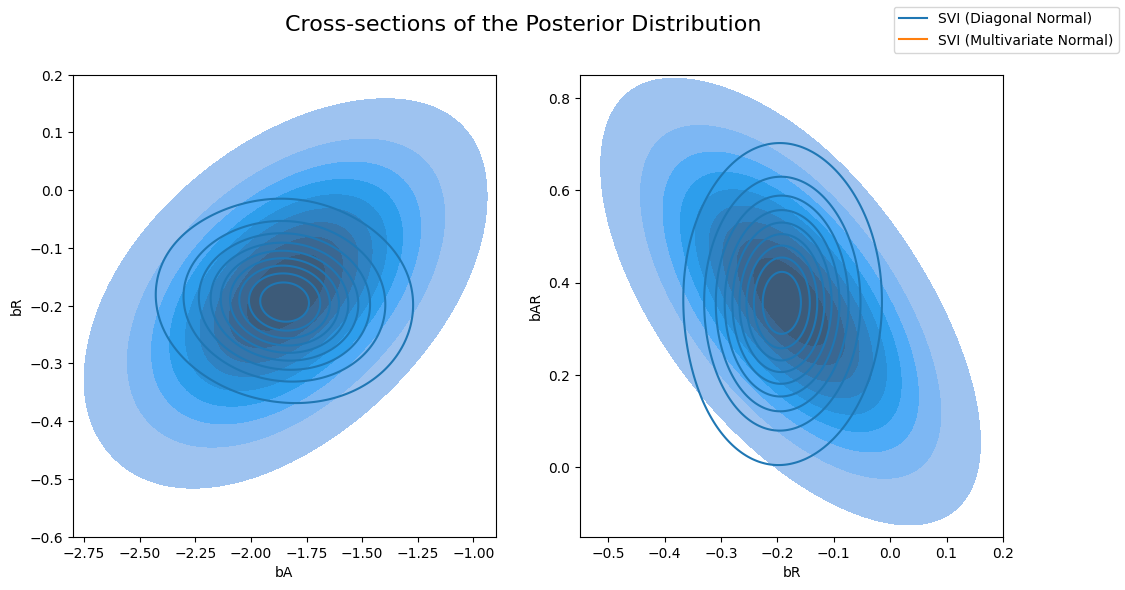

In [24]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)
    
fig.legend(loc='upper right')

We can see the implications of this by repeating our visualization of the ruggedness-GDP coefficient distribution for countries inside and outside Africa. The posterior uncertainty over each of the two coefficients is now roughly the same, in line with what eyeballing the data would suggest.

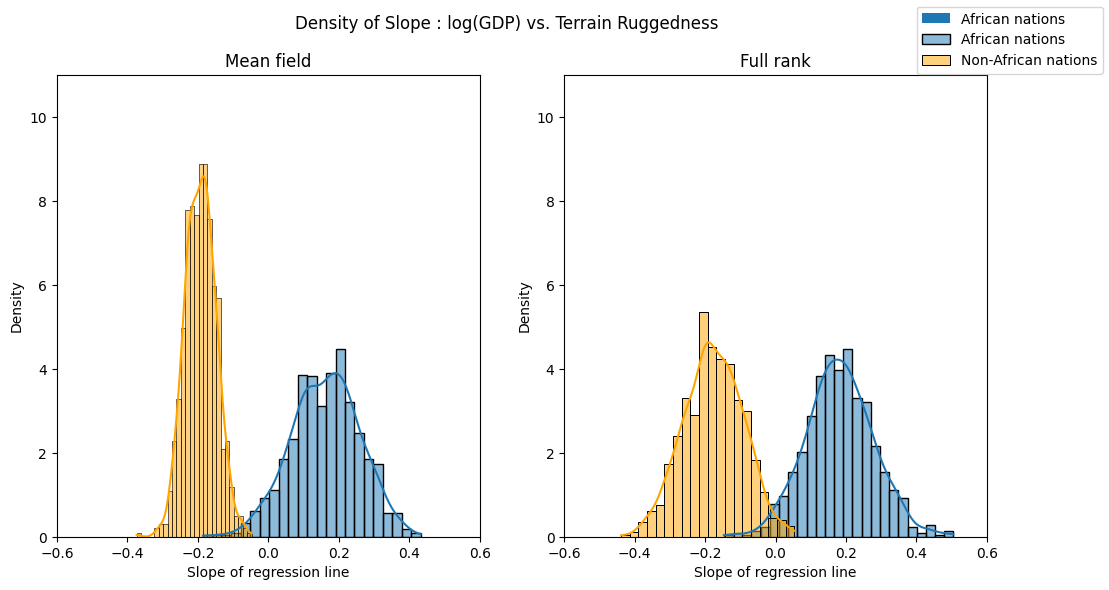

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

sns.histplot(gamma_within_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), ax=axs[0], kde=True, stat="density", color="orange", label="Non-African nations")
axs[0].set(title="Mean field", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

sns.histplot(mvn_gamma_within_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", label="African nations")
sns.histplot(mvn_gamma_outside_africa.detach().cpu().numpy(), ax=axs[1], kde=True, stat="density", color="orange", label="Non-African nations")
axs[1].set(title="Full rank", xlabel="Slope of regression line", xlim=(-0.6, 0.6), ylim=(0, 11))

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

We visualize the 90% credible interval of the posterior predictive distribution for non-African countries under both approximations, verifying that our coverage of the observed data has improved somewhat:

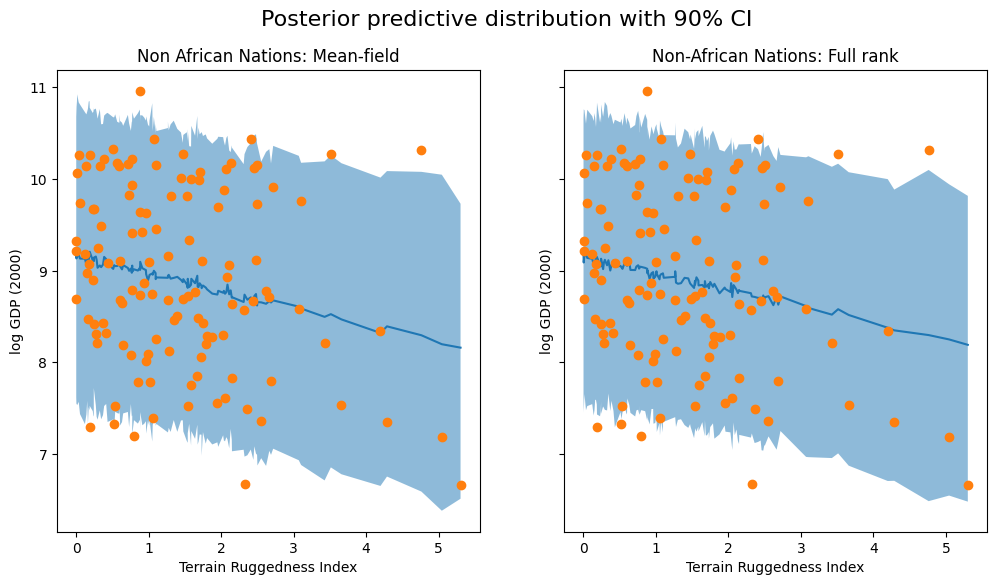

In [26]:
mvn_predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": mvn_gdp.mean(dim=0).detach().cpu().numpy(),
    "y_perc_5": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": mvn_gdp.kthvalue(int(len(mvn_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
mvn_non_african_nations = mvn_predictions[mvn_predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations: Mean-field")

ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_mean"])
ax[1].fill_between(mvn_non_african_nations["rugged"], mvn_non_african_nations["y_perc_5"], mvn_non_african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(mvn_non_african_nations["rugged"], mvn_non_african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non-African Nations: Full rank");

## Next steps

If you made it this far, you’re ready to get started using Pyro! Follow [the instructions on the front page to install Pyro](http://pyro.ai/#install) and check out [the rest of our examples and tutorials](https://pyro.ai/examples/index.html), especially the [Practical Pyro and PyTorch](http://pyro.ai/examples/#practical-pyro-and-pytorch) tutorial series, which includes [a version of the same Bayesian regression analysis in this tutorial](http://pyro.ai/examples/bayesian_regression.html) written using a more [PyTorch-native modeling API](http://pyro.ai/examples/modules.html).

For more background on the mathematics of variational inference in Pyro, check out our SVI tutorial series, starting with [Part 1](http://pyro.ai/examples/svi_part_i.html). If you’re new to PyTorch or deep learning, you may also benefit from reading the official introduction [“Deep Learning with PyTorch.”](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

Most users who reach this point will also find our [guide to tensor shapes in Pyro](http://pyro.ai/examples/tensor_shapes.html) essential reading. Pyro makes extensive use of the behavior of [“array broadcasting”](https://numpy.org/doc/stable/user/basics.broadcasting.html) baked into PyTorch and other array libraries to parallelize models and inference algorithms, and while it can be difficult to understand this behavior initially, applying the intuition and rules of thumb there will go a long way toward making your experience smooth and avoiding nasty shape errors.